### Loading _not quantized_ ML models

In [54]:
from tensorflow.keras.models import load_model
###### AE MODEL LOAD ######
ae_wo_classifier = load_model('model/AE_model/KERAS_check_best_model.h5')
ae_wo_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model.h5')
ae_w_classifier = load_model('model/AE_model/KERAS_check_best_model_classifier.h5')
ae_w_classifier_pruned = load_model('model/AE_model/KERAS_check_pruned_best_model_classifier.h5')

### Loading _quantized_ ML models

In [90]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
###### QAE MODEL LOAD ######

#qae_wo_classifier = load_model('model/QAE_model/KERAS_check_best_model.h5', custom_objects=co)
qae_wo_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model.h5', custom_objects=co)
#qae_w_classifier = load_model('model/QAE_model/KERAS_check_best_model_classifier.h5', custom_objects=co)

#qae_w_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model_only_classifier.h5', custom_objects=co)
qae_w_classifier_pruned = load_model('model/QAE_model/KERAS_check_pruned_best_model_classifier1.h5', custom_objects=co)

## Check sparsity
Make a quick check that the model was indeed trained sparse. We'll just make a histogram of the weights of the 1st layer, and hopefully observe a large peak in the bin containing '0'. Note logarithmic y axis.

In [84]:
sum = 0
sum_pru = 0

for i in [2,3,5]:
    for j in [0,1]:
        w= ae_w_classifier.layers[i].weights[j].numpy()
        sum +=w.size 
        w_prun = ae_w_classifier_pruned.layers[i].weights[j].numpy()
        sum_pru += w.size - np.sum(w_prun==0)

        if j==0:
            print('weights:')
        else:
            print('bias:')
        
        print(w.size,'\n', w.size - np.sum(w_prun==0))

    print("layer"+str(i),'\n')
print (sum, '\n',  sum -sum_pru)

weights:
225 
 34
bias:
15 
 14
layer2 

weights:
225 
 34
bias:
15 
 15
layer3 

weights:
32 
 5
bias:
16 
 10
layer5 

528 
 416


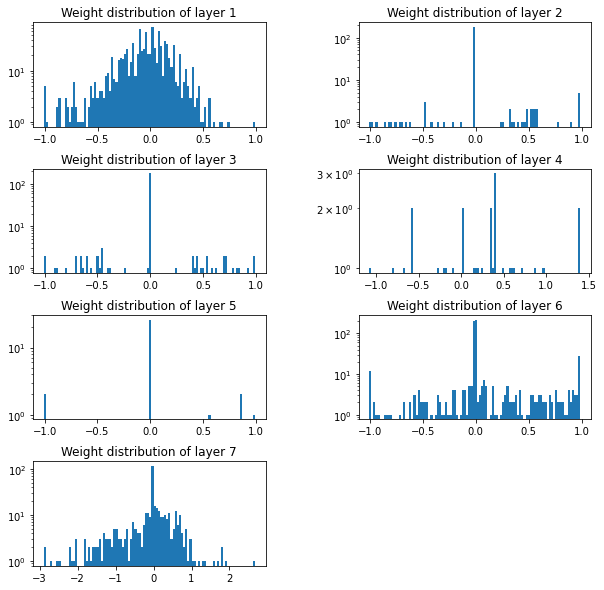

In [118]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 4
fig.subplots_adjust(hspace=0.4, wspace=0.4)

num_layers = [1,2,3,4,7,9,11]#,11,14,15]
#this applies for the quantized loop
num_layers = [1,3,5,7,8,10,12]#,11,14,15]


j = 1

for i in num_layers:
#for i in range(1, columns*rows +1):  
    fig.add_subplot(rows, columns, j)
    w = qae_w_classifier_pruned.layers[i].weights[0].numpy()
    h, b = np.histogram(w, bins=100)
    plt.bar(b[:-1], h, width=b[1]-b[0])
    plt.semilogy()
    plt.title('Weight distribution of layer '+ str(j))
    j += 1

plt.savefig('./Report/images/section4/ae_pruned_weightsdistr.png')
plt.show()


# Make an hls4ml config & model

In [2]:
import plotting
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

config = hls4ml.utils.config_from_keras_model(qae_w_classifier_pruned, granularity='name')
config['LayerName']['encoder_input']['Precision']='ap_ufixed<6,0>'

#config['LayerName']['classifier_output']['Precision'] = 'ap_fixed<32,12>'
config['LayerName']['classifier_output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['classifier_output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(qae_w_classifier_pruned,
                                                       hls_config=config,
                                                       output_dir='model/QAE_model/hls4ml_prj',
                                                       part='xcu250-figd2104-2L-e')
                                                       #part='xcvu9p-flgc2104aaz')
                                                       #part='xc7vx690t-ffg176-2')


C:\Users\loren\miniconda3\lib\site-packages\hls4ml\converters\__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


Interpreting Model
Topology:
Layer name: encoder_input, layer type: Input
Layer name: fc1, layer type: QDense
Layer name: relu1, layer type: QActivation
Layer name: fc2_prun, layer type: QDense
Layer name: relu2, layer type: QActivation
Layer name: fc3_prun, layer type: QDense
Layer name: relu3, layer type: QActivation
Layer name: encoder_output, layer type: Dense
  -> Activation (relu), layer name: encoder_output
Layer name: fc4_prunedclass, layer type: QDense
Layer name: prunclass_relu4, layer type: QActivation
Layer name: fc5_class, layer type: QDense
Layer name: class_relu5, layer type: QActivation
Layer name: classifier_out, layer type: QDense
Layer name: classifier_output, layer type: Activation
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  encoder_input
    Precision:       ap_fixed<6,0>
  fc1
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    Reus

# Compile

In [ ]:
hls_model.compile()

# Build

In [ ]:
hls_model.build(csim=True, cosim=True)

### Prediction results

In [4]:
import MNIST_database as mnist

#Choose the final size of your image dataset
size_final = 8

data_zoom = mnist.MNISTData(size_initial=20, size_final=size_final, color_depth=5, flat=True)

from matplotlib import pyplot as plt

#           0  1  2  3  4  5  6  7  8  9          
num_list = [3, 2, 1, 32,4, 15,21,0, 61,12] 



In [ ]:
#img = np.flip(data_zoom.x_test[num_list[3]].reshape(1,-1))
#img = data_zoom.x_test[32].reshape(1,-1)
#plt.imshow(img.reshape(size_final,size_final), cmap='gray_r')

[[0.      0.      0.      0.09375 0.84375 0.      0.      0.      0.
  0.      0.09375 0.96875 0.96875 0.15625 0.      0.      0.      0.
  0.96875 0.96875 0.6875  0.875   0.      0.      0.      0.      0.96875
  0.      0.      0.125   0.96875 0.      0.      0.3125  0.53125 0.
  0.      0.125   0.96875 0.      0.      0.59375 0.5625  0.      0.28125
  0.96875 0.59375 0.      0.      0.15625 0.96875 0.9375  0.9375  0.875
  0.      0.      0.      0.      0.0625  0.96875 0.28125 0.      0.
  0.     ]]


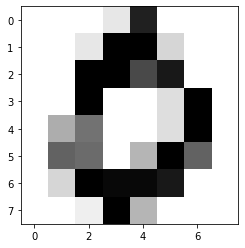

In [10]:
#img = []
ax = plt.subplot(1, 1 , 1)
img = data_zoom.x_test[num_list[0]].reshape(1,-1)

plt.imshow(img.reshape(size_final,size_final), cmap='gray_r')
print(img)
plt.imshow(img.reshape(size_final,size_final), cmap='gray_r')

--- 0.061026573181152344 seconds ---
[[3.8145399e-03 9.8177010e-01 1.7132721e-03 2.4785351e-03 2.4927363e-05
  9.2737708e-04 2.3345661e-04 7.2462396e-03 1.0432226e-04 1.6870706e-03]]
0.99999976


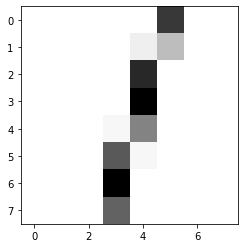

In [11]:
import time
import numpy as np
img = data_zoom.x_test[num_list[1]].reshape(1,-1)
plt.imshow(img.reshape(size_final,size_final), cmap='gray_r')
start_time = time.time()
out = qae_w_classifier_pruned.predict(img)
print("--- %s seconds ---" % (time.time() - start_time))
print(out)
print(np.sum(out))

In [ ]:
y = hls_model.predict(img)[1]
